In [1]:
# general imports usually needed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd

In [2]:
# libraries more specific to this lecture notebook
import os.path
import sys
sys.path.append('../../src')
from ml_python_class.config import DATA_DIR

from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [3]:
# notebook wide settings to make plots more readable and visually better to understand
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', titlesize=18)
mpl.rcParams['figure.figsize'] = (10.0, 8.0) # default figure size if not specified in plot

# 3. (Chapter 3) Classification

Supervised learning, as you should have learned from chapter 1, is the most 
common type of machine learning  modeling.  It involves training a model or algorithm with 
a set of labeled data so that the model can create a prediciton or hypothesis 
function $h()$, and make good predictions for data it was not trained with. 

There are basically 2 types of supervised learning.  The problem of predicting housing 
prices we did in the previous chapter is an example of a **regression** problem.  For a
regression task, we have a real valued number, and we want to learn a prediction function 
that maps inputs to the target value.

In chapter 3 and this lecture notebook we will look at the other type of supervisied learning
problem, **classification**.  Basically anytime the label you want to predict is a 
discrete categorical variable, you are doing a classification.  The simplest example 
is a binary classification.  Say that you want to build a classifier that takes e-mail
messages and classifies them as `SPAM` or `HAM`.  In this case the prediction function 
you are trying to learn needs to output a binary category, it is either spam or not 
spam.  

In this chapter we look at the MNIST data set classification problem which is an example of 
a multi-class classification task, because instead of 2 categories there are 10 
possible categories for the predicted label that we want to make.

## 3.1 MNIST

The MNIST dataset contains 70,000 smal black and white images of handwritten 
digits.  Each image is labeled with the digit category it represents (0 to 9).
MNIST is something of the "fruit fly model" in machine learning, anytime researchers
are working on developing new classification techniques they will probably try 
applying it to MNIST classification and compare its performance with other
known classifiers on the MNIST task.

Scikit-learn has many built-in datasets you can use to learn about ML techniques,
and the MNIST dataset is one of them.  Lets start by fetching the data and 
doing a little exploration to see what is in it.

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

What is loaded is actually a standard python dictionary.  We can extract the 
data and the labels (also called targets) from the dictionary to use.

All datasets we get from `sklearn` are returned as dictionaries like this.  All of the
data items will be regular `numpy` arrays.

In [5]:
X, y = mnist['data'], mnist['target']

print(type(X))
print(X.shape)
m,n = X.shape # extract the number of samples m and number of feature attributes n
print('Number of samples in dataset: ', m)
print('Number of feature attributes: ', n)

print(type(y))
print(y.shape)

<class 'numpy.ndarray'>
(70000, 784)
Number of samples in dataset:  70000
Number of feature attributes:  784
<class 'numpy.ndarray'>
(70000,)


There are 70,000 images.  Each has 784 features.  This is because each sample is
actually grayscale image with $28 x 28 = 784$ pixels, where the pixel values range
from 0.0 to 1.0.

We can visualize what the handwritten digits look like by reshaping them in 28x28 
pixel images and plotting them.

image label:  7


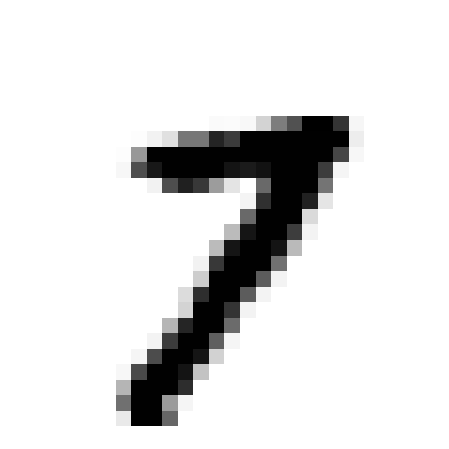

In [6]:
sample_num = 40000
some_digit = X[sample_num]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off");

print("image label: ", y[sample_num])

Notice that the label matches the digit.  You can randomly look at other samples of 
digits in the above cell and see what the data looks like and that the label 
matches the sampled image.

The label we get is actually a string.  We need this to be a numerical value for
our machine learning classifier, so we will go ahead and convert the labels now.

In [7]:
print(type(y), y.dtype)
y = y.astype(np.uint8) # convertes to an integer using 8 bits, but we only need 4 bits here
print(type(y), y.dtype)

<class 'numpy.ndarray'> object
<class 'numpy.ndarray'> uint8


Lets look at a few more MNIST digits to get a feel for the classification task.

In [8]:
def plot_digits(samples, images_per_row=10, **options):
    """Plot a set of MNIST samples.  
    """
    size = 28
    images_per_row = min(len(samples), images_per_row)
    images = [instance.reshape(size,size) for instance in samples]
    n_rows = (len(samples) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(samples)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

[[5 0 4 1 9 2 1 3 1 4]
 [3 5 3 6 1 7 2 8 6 9]
 [4 0 9 1 1 2 4 3 2 7]
 [3 8 6 9 0 5 6 0 7 6]
 [1 8 7 9 3 9 8 5 9 3]
 [3 0 7 4 9 8 0 9 4 1]
 [4 4 6 0 4 5 6 1 0 0]
 [1 7 1 6 3 0 2 1 1 7]
 [9 0 2 6 7 8 3 9 0 4]
 [6 7 4 6 8 0 7 8 3 1]]


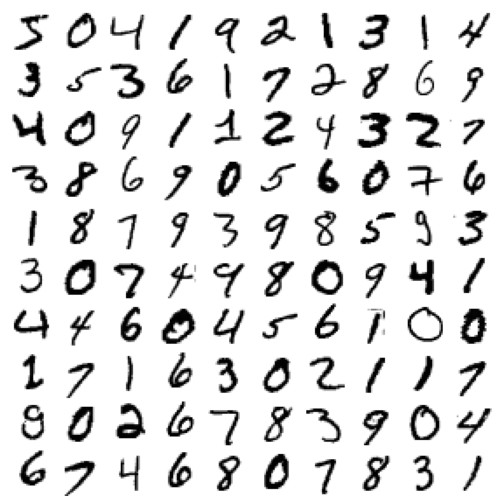

In [9]:
plt.figure(figsize=(9,9))

# display the first 100 MNIST digits
example_images = X[:100]
plot_digits(example_images, images_per_row=10)

# display the labels of these digits
print(y[:100].reshape((10,10)))

The MNIST dataset has already been shuffled (as you can kind of see from the
previous image).  It has also been organized such that the first 60,000 samples 
are usually considered to be the images needed for training, and the remaining 
10,000 samples are the test set.  So we will split out our train and test sets 
now for use in building a classifier.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(X_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


## 3.2 Training a Binary Classifier

Lets simplify and first just build a binary classifier, a 5-detector.  The task 
then is we want to ouput a true when the image is a 5, and a false when it is any 
other digit.

We can create a new set of binary labels, for both the training and test set, 
easily enough using vectorized operations.

In [11]:
y_train_5 = (y_train == 5) # result is an array of booleans, true for all 5s
y_test_5 = (y_test == 5)

print(y_train_5.shape)
print(y_train_5[:10])

(60000,)
[ True False False False False False False False False False]


In `sklearn` objects that work as classifiers usually have `Classifier` on the end 
of their name, like you saw for `Regression` learners previously.  

A simple classifier to try is Stochastic Gradient Descent (SGD), using 
`sklearn` `SGDClassifier` class.  This classifier is "stochastic" or 
random because it will pick one or a small patch of training samples at random
to train a bit, then select another sample at random.  

The default fitness function for the `SGDClassifier` should work fine for this
binary classification task, so lets try it out.

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Once the model has been trained (fitted), we can use it to predict.

In [13]:
sample_num = 0
some_digit = X[sample_num]

print(y_train_5[sample_num])
print(sgd_clf.predict([some_digit]))

sample_num = 1
some_digit = X[sample_num]

print(y_train_5[sample_num])
print(sgd_clf.predict([some_digit]))

True
[ True]
False
[False]


## 3.3 Performance Measures

Evaluation a regression is relatively simple.  Each individual hypothesis can measure 
the magnitude of the error made, and an average of these error magnitudes gives a good 
idea of how well the regression performs overall.

Evaluating a classification is tricker.  For example, for a multi-class problem 
is the error really bigger if you guess a 9 when the answer is 4 than if you guess a 5?

### Measuring Accuracy using Cross-Validation

We will start by using K-fold cross-validation as we did before.

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

You will get above 93% or 94% accuracy usually.  That looks pretty good, right?

But you need to always be aware of the task you are performing, and always compare to
a dead simple baseline.  For example, what accuracy would you expect to get if you
always guess that the image is not a 5?

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Since 90% of the samples are not-5s, you will get roughly 90% accuracy by always guessing 
false that the image is a 5.  

So while our SGD classifier looks like it is doing something, it may not be performing quite 
as well on the classification task as we would like.

This demonstrates why accuracy is generally not the preferred performance measure for 
classifiers, especially when you are dealing with _skewed datasets_ (i.e. when some classes are
much more frequent than others).

### Confusion Matrix

For a binary classifier like this, one of the first things we want to look at is the 
**confusion matrix**.  We can count all the times it was correct (true positives and 
true negatives).  But when it is incorrect,
we can count the false positives (we guessed a 5 when it was not a 5) and false negatives
(we guess not 5 when it was in fact a 5).

We again want to evaluate using part of the training data, the validation set. 
We can again do cross validation, but use `sklearn` `cross_val_predict()` 
to instead return predictions instead of the final accuracy score.

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred.shape)

(60000,)


What has just happened is that we have gotten a prediction for each of our 60,000 
training images.  But the predictions were from cross-validation, so they were the
predictions when the sample was held back from training with 40,000 of the samples that 
were used to predict the other 20,000.

Given the predictions from cross-validation we can create a confusion matrix using 
`sklearn` `confusion_matrix()` function.

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

It takes some interpretation to understand the confusion matrix output here.  Each 
row represents an **actual class** (true label), while each column represents a
**predicted class**.  For binary classification it is always negative, positive.  
So the first row is the actual negatives, and first column is negative predictions.
So in otherwords there are 53892 true negatives (your result can vary a bit if you rerun the notebook). Or in otherwords the model was corect this many times at guessing not 5 when it 
was not a 5.  The value in row 2 column 2 is the true positives, so when I ran the 
model correctly identified 3530 images as being 5.

The off diagnol represents the false positives and false negatives.  Here row 2 column 1
is where the actual class is true, but the prediction was false, so a false negative.
So 1891 times the classifier was given a 5 it predicted it was not a 5.
Then row 1 column 2 is false positives, so 687 times the actual class was false (not a 5)
but the classifier guessed it was a 5.

A perfect classifier would only have true positives and true negatives, so the off diagnol
would all be 0.

In [19]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

The confusion matrix gives a lot of raw information, and it is often best to look at it
directly.  But sometimes we may prefer more concise metrics.  Thus a lot of times measures of
**precision** and **recall** are reported for classification tasks like this.

The accuracy of the positive predictions is called the **precision** of the classifier.
It is calculated like this:

$$
precision = \frac{TP}{TP + FP}
$$

Where TP stands for true positives and FP is the number of false positives. 
We could calculate this measure ourself, it is simple, or use `sklearn` to do it for us

In [20]:
# calculate by hand using the values we got from run above
TP = 3530
FP = 687
precision = TP / (TP + FP)
print(precision)

0.8370879772350012


In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

Precision is how precisely accurate our predictions are.  So a precision of 0.83 means 83%
of the time when we say it is a 5 it is a 5.

Precision alone doesn't tell you all you need to know.  For example, if you only
restrict yourself to guessing something is a 5 1 time, when you are most certain it is a 
5, then your precision will be $1 / 1 = 100\%$.  

But always being right when you are 
guessing it is a 5 doesn't tell you how many times you miss saying something is a 5
when it is not.  The recall measure gets at this concept.  Recall is a measure of 
the ratio of positive instances that are correctly classified by the classifier.
it is measured as:

$$
recall = \frac{TP}{TP + FN}
$$

Again this is simple enough we can calculate it by hand, though `sklearn` has functions
for both recall and precision.


In [22]:
# calculate by hand using the values we got from run above
TP = 3530
FN = 1891
recall = TP / (TP + FN)
print(recall)

0.6511713705958311


In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311


Finally there is even another measure that is sometimes used, called the **$F_1$ score**
that combines the recall and precision into a single summary metric. $F_1$ will only be high 
when both precision and recall are high.  It is calculated as:

$$
F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

If you are confused about the confusion matrix, and what precision and recall mean,
the following figure from our textbook should help.

![title](../../figures/homl-fig-3-2-confusion-matrix.png)

I personally find the raw confusion matrix the best source of information about how the 
binary classifier is doing.  But as you can see here, precision is 3 out of 4 in the
sample performance shown, meaning that when we say it is a 5 (a positive) we are 
correct about 75% of the time.
And recall is 3 out of 5, meaning we are only finding 60% of the positive instances 
in the tests.

### Precision/Recall Tradeoff

One thing to note is that both precision and recall are mainly concerned with the detection of the
positive examples.  In a binary classification task this is often the thing of most interest.  
For example, if you are trying to build a classifier that detects cancer or no cancer, you are
greatly interested in the true positive rate of successfully predicting cancer when cancer is
actually present.

The false positives and false negatives will be of greater or lesser importance depending on 
the nature of the binary classificaiton task.  For detecting a life threteaning disease, you 
really want to reduce the false negative rate as much as possible.  This represents 
times when your classifier predicts the patient is safe, when in fact they have cancer.  False negatives
thus make it more likely the patient will die since they will not realize they are sick and 
seek further treatment.  A false positive in this case still is not good.  It means that the 
patient is told they may have cancer when they in fact do not.  So time, effort and stress will
result in following up with more diagnosis or treatment that are not needed. 

But in other applications, it might be of much more concern to be wasting these resources on
false positives than to be missing identifications because of false negatives.

As discussed in our text there is often a tradeoff between precision and recall, which is basically 
the tradeoff between false positives and false negatives we were just discussing.
Often for a given trained classifer there is a decision threshold.  Changing the decision 
threshold will effect precision and recall in opposite directions.  The only way to do better is
to train a better classifier that is more likely to be correct and certain in its predictions of
negative and positivie examples.

`Scikit-Learn` does not let you set the threshold directly, but you can access the decision scores used to 
make the predictions.  Instead of calling the `predict()` method that applies the built-in threshold 
for a classifier, you can call the `decision_function()` method instead, which returns a score 
for each instances (usually, some classifiers cannot do this).  Then you can set your own threshold.

For example, you can observe the precision/recall tradeoff by using our SGD trained classifier and 
trying to change the threshold.

In [25]:
sample_num = 0
some_digit = X[sample_num]

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


The `SGDClassifier` uses a threshold of 0, so positive scores are classified as true and negative 
as false.  So of course if we rais the threshold above the score for our first sample, 
it will now (incorrectly) predict it is not a 5

In [27]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


How do we decide what threshold to use.  A common tactic is to plot recall and precision as a result of 
modifying the threshold.

First lets get the scores of all instances in the training set using the `cross_val_predict()` method 
again, but this time we specify we want to return decision scores instead of the final predictions.

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With these scores we can compute precision and recall for a range of possible thresholds.
Again we could do this ourself, but `sklearn` has a function for that.

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

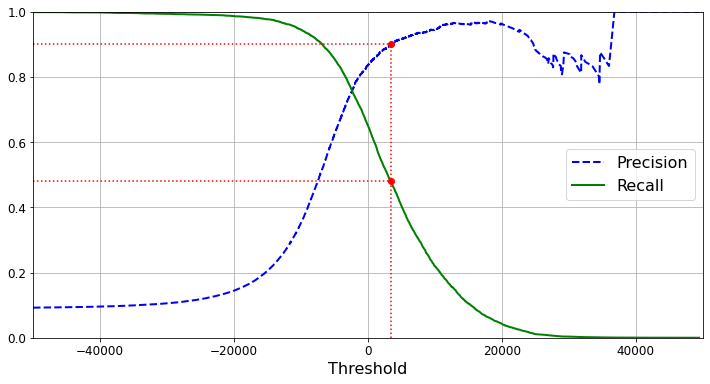

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(12, 6))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro");                            # Not shown

A similar figure that can be used to determine a good tradeoff is to simply plot recall and precision 
directly against one another.

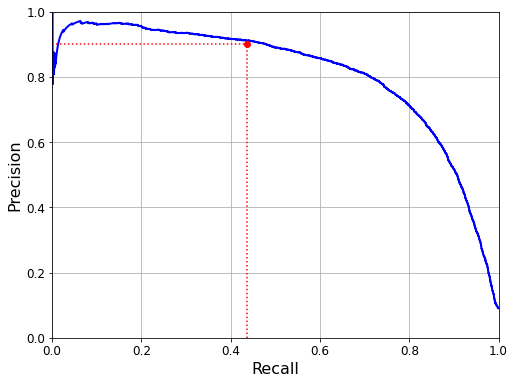

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro");

In both figures, the added red threshold lines are answering the question: If I require a precision 
of 0.9, what is the effect on recall?

You can see that precision really starts to fall around 80% recall.  You will probably want to select a
precision/recall tradeoff just before that drop, for example at around 60% recall. But the choice 
depends on the project.  Again for the cancer example, if you want to reduce the false negative, 
you want to pick a higher recall at the cost of precision.

The plots illustrate searching for a particular value of precision.  If you want to 
achieve 90% precision, you can search for the lowest threshold that gives you at least 90% precision
using `np.agrmax()`.

In [32]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439594


In [33]:
# check precision and recall for this threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)

print("Precision: ", precision_score(y_train_5, y_train_pred_90))
print("Recall   : ", recall_score(y_train_5, y_train_pred_90))

Precision:  0.9000345901072293
Recall   :  0.4799852425751706


So it is easy to get a classifier that meets a target precision (or recall) score.  But a high precision
(or high recall) classifier is not very useful if the other measure is to low because of this
tradeoff.

### The ROC Curve

The **receiver operating characteristric** (ROC) curve is a similar idea to plotting recall/precision
tradeoffs that is popular in other ML subcommunities.

Instead of plotting precision vs. recall, the ROC curve plots the true positive rate (another name for recall)
against the false positive rate.  Personally I find directly using the true positive and false positive 
rates more understandable, thus kind of prefer an ROC curve. The false positive rate is equal to one 
minus the true negative rate.  The true negative rate (TNR) is also sometimes called specificity.  

Hence the ROC curve plots sensitivity (same thing as recall) versus 1 - specificity (or 1 - TNR).

`sklearn` also has functions to help plot this tradeoff curve, the `roc_curve()` function:

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

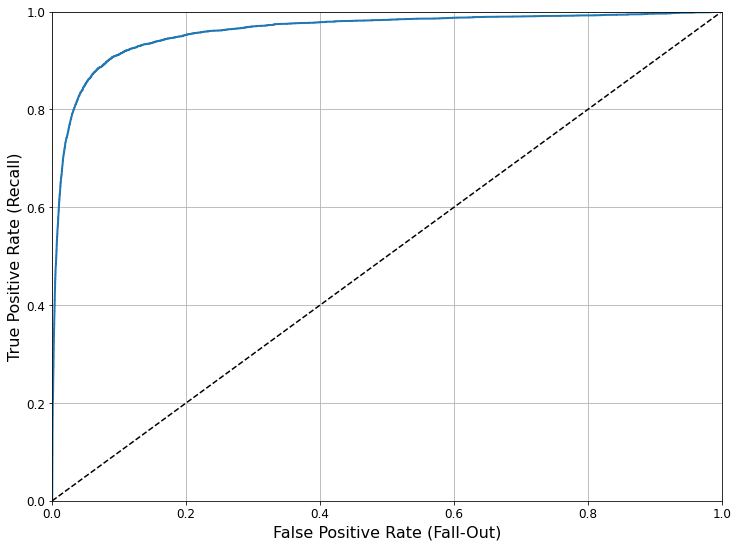

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(12, 9))                         # Not shown
plot_roc_curve(fpr, tpr)


The ROC curve illustrates the tradoff we directly get when changing the threshold between the true positive 
rate and the false positive rate.  The higher the TPR, the more falls positives FPR the classifier 
produces.  

The dotted line represents the ROC curve of a purely random classifier.  One way to judge your classifier 
is by how far away from that line it stays (towards the top-left corner).

So sometimes the area under the curve (AUC) of the  ROC plot is calculated to compare the performance of different 
binary classifiers.  You can see a perfect classifier will end up with an ROC AUC of 1.  A classifier 
performing randomly ends up with an ROC AUC equal to 0.5.  `sklearn` provides a function to compute 
the ROC AUC.

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

You may wonder which to use, precision/recall or ROC curve when evaluating the performance of 
a binary classifier.  The book gives some good rules of thumbs.

You should prefer precision/recall tradeoff curve whenever the positive class is rare or when you care 
more about false positives than the false negatives, and the ROC curve otherwise.

In our binary 5-detector, the positive cases are relatively rare, only 10% of the time do we see 5's.
So for example again looking at the ROC curve (and the ROC AUC score), you may think that the SGD 
classifier is pretty good.  But this is mostly because there are few positives (5s) compared to the
negatives (non-5s).  In contrast the precision/recall curve makes it clear that the classifier has room 
for imporvement (the cuve could be closer to the top-right corner).

Lets train a better classifier to see how much improvement might be possible for this binary
classification task and compare its ROC curve and ROC AUC score to the `SGDCLASSIFIER`.

We will try a `RandomForestClassifier`.
We need to get scores for each instance in the training set.  But because of the way a random
forest classifier works, it does not implement a `decision_function()` method.  Instead we need
to use a method called `predict_proba()`.  This method returns an array with one row per sample 
instance, and 1 column per class, each containing the probability that the given instance 
belongs to the given class.

Lets create and train our `RandomForestClassifier` on the binary 5-detector problem.

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

To plot a ROC curve we need scores, not probabilities.  A simple solution is to use the 
positive class's probability as the score.

In [38]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

With the scores, we can plot the ROC curve as before and compute the ROC AUC score. We plot
the SGD and the Random Forest classifiers together for comparison.

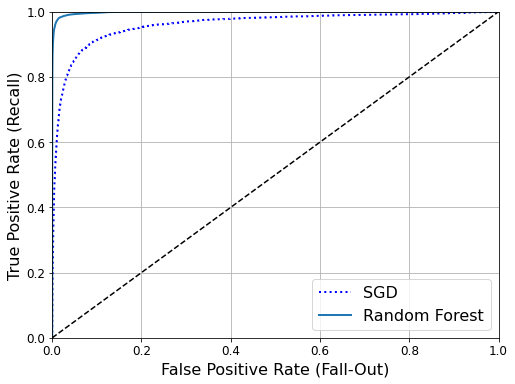

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16);

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

The ROC curve of the random forest is much better, to comes much closer to the top-left corner.
Also the ROC AUC score is significantly better as well.  Measuring the precision and recall we 
get about 99% precision and 86.5% recall.

In [41]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

print("Precision score: ", precision_score(y_train_5, y_train_pred_forest))

print("Recall score   : ", recall_score(y_train_5, y_train_pred_forest))

Precision score:  0.9905083315756169
Recall score   :  0.8662608374838591


In summary for this part on binary classifiers.  You have now seen an example of training a
binary classifier, and evaluating the classifiers using cross-validation again.
We looked at accuracy as a measure, but quickly concluded this can be
problematic, or at least misleading for a classification task.    We instead compared various
measures that capture the tradeoff in performance of a model, recall/precision and the ROC 
curve.  These are the basic tools you need for binary classification.

Now lets try and build a multi-class classifier to detect more than just the 5s/not-5s.

In [42]:
# display version information of library versions used in 
from ml_python_class.custom_funcs import version_information
version_information()

              Module   Versions
--------------------   ------------------------------------------------------------
         matplotlib:   ['3.3.0']
              numpy:   ['1.18.5']
             pandas:   ['1.0.5']
            seaborn:   ['0.10.1']
